In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input,GRU, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('final_travel_time.csv')

In [17]:
df.head()

,road_segment,datetime,travel_time
0,0,2019-12-23 05:00:00,1.864865
1,0,2019-12-05 05:00:02,1.619718
2,0,2019-12-12 05:00:04,1.751269
3,0,2019-12-29 05:00:04,1.932773
4,0,2019-12-12 05:00:05,2.284768


In [18]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [19]:
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['is_peakhour'] = df['hour'].apply(lambda x: 1 if (8 <= x <= 11 or 16 <= x <= 18) else 0)
df['is_weekend'] = df['datetime'].dt.dayofweek.apply(lambda x: 1 if x == 5 else 0)
df.head()

,road_segment,datetime,travel_time,hour,minute,is_peakhour,is_weekend
0,0,2019-12-23 05:00:00,1.864865,5,0,0,0
1,0,2019-12-05 05:00:02,1.619718,5,0,0,0
2,0,2019-12-12 05:00:04,1.751269,5,0,0,0
3,0,2019-12-29 05:00:04,1.932773,5,0,0,0
4,0,2019-12-12 05:00:05,2.284768,5,0,0,0


In [20]:
features = ['road_segment','hour', 'minute', 'is_peakhour', 'is_weekend']
target = 'travel_time'

In [21]:
X = df[features].values
y = df[target].values

In [22]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

In [23]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [24]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [26]:
model = Sequential([
    Input(shape=(1, len(features))),
    GRU(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    GRU(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [28]:
history = model.fit(X_train, y_train, epochs=500, batch_size=64, 
                    validation_split=0.2, verbose=1)

Epoch 1/500


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0399 - val_loss: 0.0199
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - val_loss: 0.0191
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - val_loss: 0.0189
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0191
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0183
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - val_loss: 0.0174
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - val_loss: 0.0171
Epoch 8/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.0166
Epoch 9/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0162
Epoch 10/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - val_loss: 0.0160
Epoch 11/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - val_loss: 0.0159
Epoch 12/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_l

In [29]:
model.save('gru_travel_time.keras')

In [30]:
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss (MSE): {loss}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 
Test Loss (MSE): 0.004089800640940666


In [31]:
y_pred_scaled = model.predict(X_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [32]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

In [33]:
results = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_pred.flatten()})
print(results.head())

     Actual  Predicted
0  5.071823   5.098496
1  3.445545   2.288268
2  4.515789   5.406408
3  4.285714   4.146089
4  2.706625   3.107570


In [34]:
mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.7185519452791915


In [35]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.0704384024049989


In [36]:
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Percentage Error: 19.60178142945674%


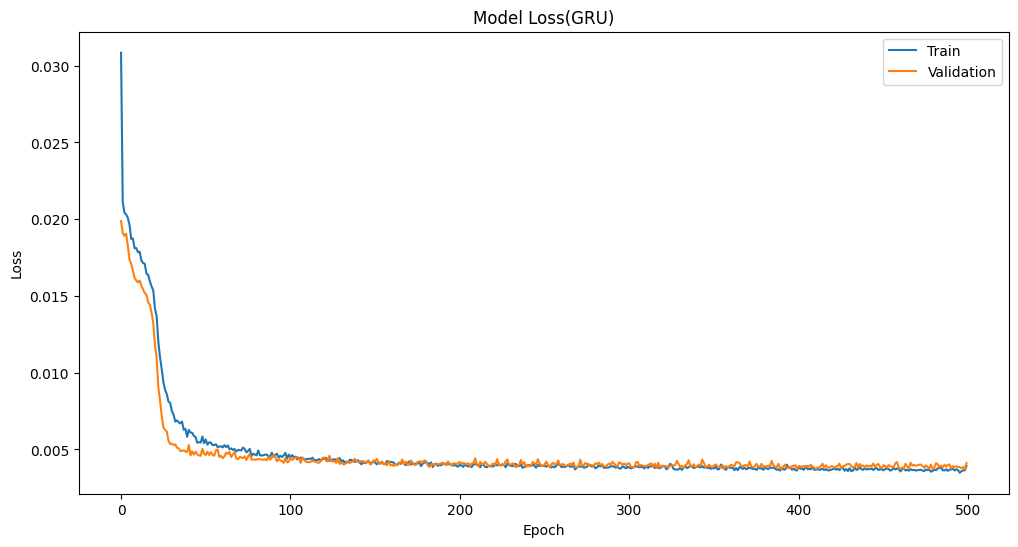

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss(GRU)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('training_validation_loss.png')
plt.show()

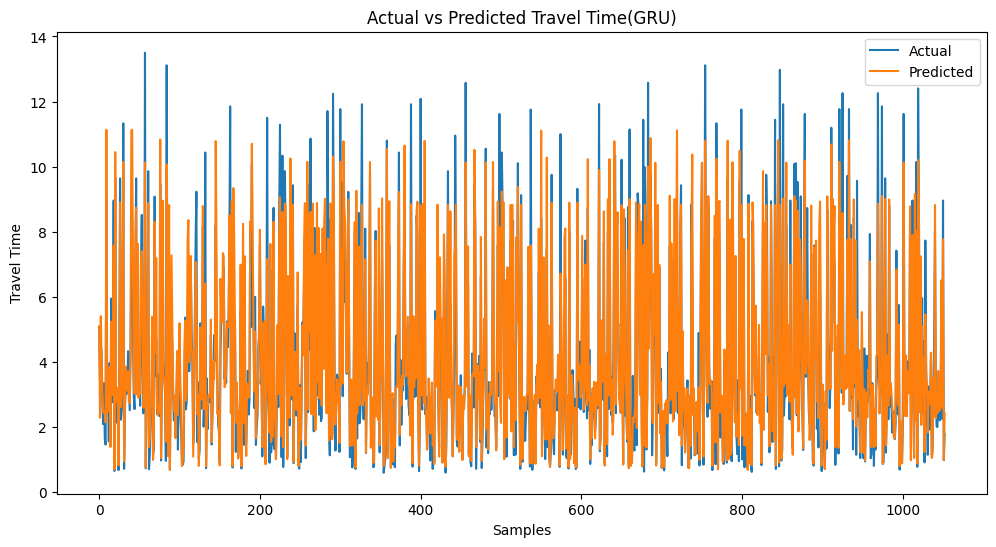

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Travel Time(GRU)')
plt.xlabel('Samples')
plt.ylabel('Travel Time')
plt.legend()
plt.savefig('Actual vs Predicted Travel Time.png')
plt.show()

In [39]:
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [40]:
def calculate_accuracy(expected_times, actual_times):
    n = len(expected_times)    
    sum_term = sum(1 - abs((expected_times[i] - actual_times[i]) / actual_times[i]) for i in range(n))
    accuracy = (sum_term / n) * 100
    return accuracy

In [41]:
accuracy = calculate_accuracy(y_test_actual.flatten(), y_pred.flatten())
print(f"Accuracy on Validation Set: {accuracy:.2f}%")

Accuracy on Validation Set: 82.85%


In [42]:
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.1458383733433661
